# AI Tools

## Project - Airlines AI Assistant

We will make an AI Customer Support assistant for an Airline with pre-fixed prices

In [26]:
# Importing the Libraries

import requests
import json
import time
import re
import ollama
from typing import List
from IPython.display import Markdown, display, update_display
from bs4 import BeautifulSoup
import gradio as gr

In [27]:
# Initializing System Messages and ollama details

system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

OLLAMA_URL = "http://localhost:11434/api/chat"
MODEL_NAME="qwen3"

### Tools
Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

In [28]:
# Let's start by making a useful function

ticket_prices = {"chennai": "₹ 399", "mumbai": "₹ 899", "bengalore": "₹ 400", "hydrabad": "₹ 499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "")

In [29]:
# There's a particular dictionary structure that's required to describe our function:

# Tool Name
price_function = {
        "name": "get_ticket_price",  # Name of the function
        # This is important since its passed to LLM so that when it should call the tool we have to mention it clearly, its like system prompt for tools. Be clear as possible 
        "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
        "parameters": {
            # Here we have to give the details of the parameters, here we have one parameter so mentioning that here
            "type": "object",
            "properties":{
                "destination_city":{
                    # Mentioning the data type and where and how this input is used
                    "type": "string",
                    "description": "The city that the customer wants to travel to",
                },
            },
            # we have to mention what are the must required parameters of the function(tool)
            "required":["destination_city"],
            # It restricts the input object to allow only the explicitly defined properties — no extras.
            # like only "destination_city": "Berlin" this is allowed they can't send extra prameters like "class": "economy"
            "additionalProperties": False,
        }
    }

In [30]:
# And this is included in a list of tools:

tools = [
    {
        "type": "function",  # Since we are calling the function we have to mention it
        "function": price_function,
    }
]

In [31]:
# We have to write that function handle_tool_call:

import uuid
def handle_tool_call(message):
    tool_call = message["tool_calls"][0] # Since we are using only one tool we are getting the first one
    arguments = tool_call["function"]["arguments"]
    if isinstance(arguments, str):
        arguments = json.loads(arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)

    tool_call_id = tool_call.get("id", str(uuid.uuid4()))
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": tool_call_id
    }
    return response, city

In [41]:
# For tools we are going to use ollama package instead of APIs(Since APIs don't support tools)
# This tools support will be provides by only specific models so we switch to Qwen from Mistral

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    result = ""
    try:
        response = ollama.chat(
            model=MODEL_NAME,
            messages=messages,
            tools=tools,
            stream=False,
            options={
                "temperature": 0.8
            }
        )
        print(response, "\n")

        msg = response.get("message", {})
        if msg.get("tool_calls"):
            print(msg.get("tool_calls"))
            tool_response, city = handle_tool_call(msg)
            messages.append(msg)
            messages.append(tool_response)
            response = ollama.chat(
                model=MODEL_NAME,
                messages=messages,
                stream=False,
                options={
                    "temperature": 0.8
                }
            )

            msg = response.get("message", {})
            
        if msg.get("content"):
            return {"role": "assistant", "content": msg["content"]}
        
        return {"role": "assistant", "content": "I'm not sure how to respond."}
                    
    except Exception as e:
        print("Exception: ", repr(e))

In [42]:
# Chat Interface

gr.ChatInterface(fn=chat, chatbot=gr.Chatbot(type="messages")).launch(inline=False)

/home/alexender/Desktop/Projects/My_projects/envs/Torch_env/lib/python3.12/site-packages/gradio/chat_interface.py:328: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'messages', will be used.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Let's build a multi-model App
We can use a Free image generation API called pollinations.ai and SubNP, the image generation model we can choose, to make us some images

Let's put this in a function called artist.


In [43]:
import base64
from io import BytesIO
from PIL import Image

In [44]:
# from PIL import Image
# from IPython.display import display
# from io import BytesIO

# # Image parameters
# prompt = 'Generate image of Joseph Stalin waving the red flag in front of the red army soviet'
# width = 1024
# height = 1024inline=False
# seed = 42   # Each seed generates a new image variation
# model = 'flux' # Using 'flux' as default if model is not provided

# # Construct the image URL
# image_url = f"https://pollinations.ai/p/{prompt}?width={width}&height={height}&seed={seed}&model={model}"

# # Fetch and display the image without saving
# response = requests.get(image_url)
# img = Image.open(BytesIO(response.content))
# display(img)

In [45]:
def artist(city):
    model = 'flux' # Using 'flux' as default if model is not provided
    prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style"
    width = 1024
    height = 1024
    seed = 42   # Each seed generates a new image variation

    # Construct the image URL
    image_url = f"https://pollinations.ai/p/{prompt}?width={width}&height={height}&seed={seed}&model={model}"

    # Fetch and display the image without saving
    response = requests.get(image_url)
    
    return Image.open(BytesIO(response.content))

In [50]:
image = artist("India")

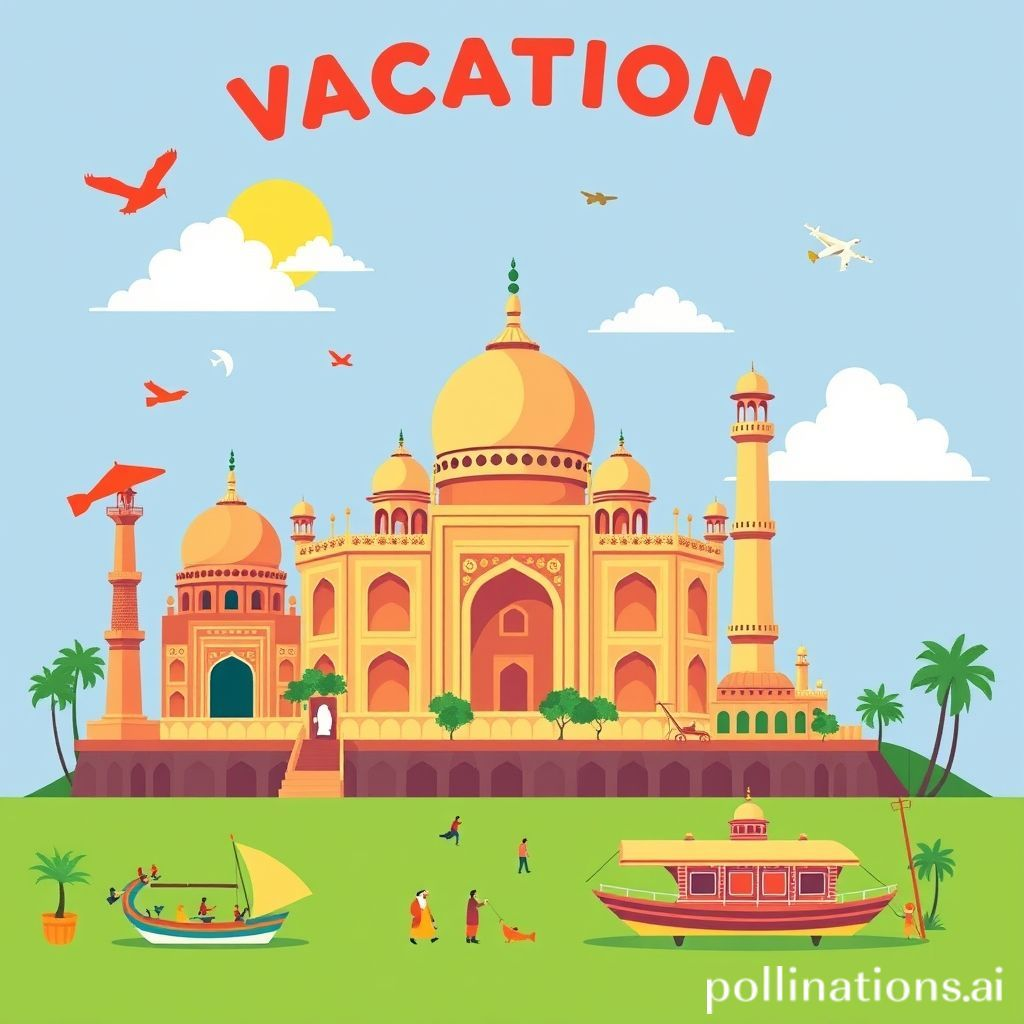

In [51]:
display(image)

We are using Audio models also for this multi Agent, so for this we use gTTS 

gTTS (Google Text-to-Speech), a Python library and CLI tool to interface with Google Translate's text-to-speech API.

For different Languages refer this -->https://gtts.readthedocs.io/en/latest/module.html#languages-gtts-lang

Optional, There is a free API for this called TTSMP3 api, if required we can use that for different modulation

In [67]:
# Install it if its not installed

# !pip install gTTS

In [76]:
from IPython.display import Audio
from gtts import gTTS
import io

def talker(message):
    # Create the TTS object
    tts = gTTS(text=message, lang='en')
    
    # Save to a file
    # tts.save("output.mp3")
    
    mp3_fp = io.BytesIO()
    tts.write_to_fp(mp3_fp)
    
    # Seek to the start so IPython can read it
    mp3_fp.seek(0)
    
    # Play the audio directly in JupyterLab
    return Audio(mp3_fp.read(), autoplay=True)

In [77]:
talker("mangekyou sharingan")

### Our Agent Framework
The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

* Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
* The ability for LLMs to use Tools to give them additional capabilities
* The 'Agent Environment' which allows Agents to collaborate
* An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
* The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

In [93]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history

    result = ""
    image = None
    try:
        response = ollama.chat(
            model=MODEL_NAME,
            messages=messages,
            tools=tools,
            stream=False,
            options={
                "temperature": 0.8
            }
        )
        print(response, "\n")

        msg = response.get("message", {})
        if msg.get("tool_calls"):
            print(msg.get("tool_calls"))
            tool_response, city = handle_tool_call(msg)
            messages.append(msg)
            messages.append(tool_response)
            response = ollama.chat(
                model=MODEL_NAME,
                messages=messages,
                stream=False,
                options={
                    "temperature": 0.8
                }
            )

            image = artist(city)
            msg = response.get("message", {})
            
        if msg.get("content"):
            cleaned_reply = re.sub(r"<think>.*?</think>", "", msg["content"], flags=re.DOTALL).strip()
            audio = talker(cleaned_reply)
            display(audio)
            history.append({"role": "assistant", "content": msg["content"]})
            return history, image
        
        history.append({"role": "assistant", "content": "I'm not sure how to respond."})
        return history, image
                    
    except Exception as e:
        print("Exception: ", repr(e))
        history.append({"role": "assistant", "content": f"An error occurred: {str(e)}"})
        return history, None

In [94]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True, inline=False)

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.


model='qwen3' created_at='2025-09-05T16:19:55.722203879Z' done=True done_reason='stop' total_duration=15928024164 load_duration=134779213 prompt_eval_count=225 prompt_eval_duration=237019756 eval_count=70 eval_duration=15546907147 message=Message(role='assistant', content='<think>\nOkay, the user said "hello there." I need to respond politely and briefly. Since there\'s no specific query here, I should just greet them back and offer help. No need to call any functions because they didn\'t ask for anything. Keep it friendly and open-ended.\n</think>\n\nHello! How can I assist you today?', thinking=None, images=None, tool_calls=None) 



model='qwen3' created_at='2025-09-05T16:20:42.412230342Z' done=True done_reason='stop' total_duration=30233703562 load_duration=70802771 prompt_eval_count=247 prompt_eval_duration=1864660699 eval_count=116 eval_duration=28263856484 message=Message(role='assistant', content='<think>\nOkay, the user said "hello good morning". I need to respond in a short, courteous way, no more than one sentence. Since they greeted me, I should acknowledge their greeting and offer assistance. Let me check if there\'s any function I need to call here. The tools provided are for getting ticket prices, but the user hasn\'t asked for that yet. They just said hello. So, no function call is needed. Just a friendly response. Let me make sure to keep it concise.\n</think>\n\nGood morning! How can I assist you today?', thinking=None, images=None, tool_calls=None) 

